# Getting Started With Histlite

In this brief tutorial, we introduce the basics of creating, manipulating, and plotting histograms using histlite.

.. contents:: :local:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import histlite as hl

%matplotlib inline

In [2]:
# I prefer a reordered color cycle
from cycler import cycler
mpl_colors_orig = np.array (plt.matplotlib.rcParamsDefault['axes.prop_cycle'].by_key()['color'])
mpl_colors = mpl_colors_orig[[0, 3, 2, 1, 4, 5, 6, 7]]
plt.rc ('axes', prop_cycle=cycler ('color', mpl_colors))

## First histogram

For our first histogram, let's use some normally-distributed random data and default binning in one dimension:

In [3]:
x = np.random.normal (size=10**4)

In [4]:
h = hl.hist (x)

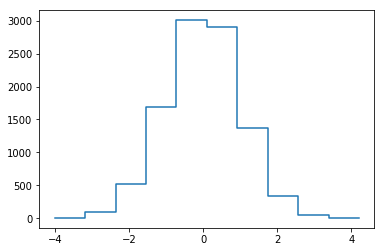

In [5]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h)

We immediately notice that for this type of data, it may be useful to select symmetric binning including a central bin at 0:

In [6]:
h = hl.hist (x, bins=51, range=(-5, 5))

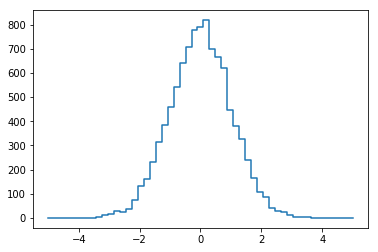

In [7]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h)

Histlite keeps track of per-bin error estimates, and we can display them with many different styles.  Let's try plotting with errorbars, errorbands, errorbands with smooth lines rather than steps, and crosses:

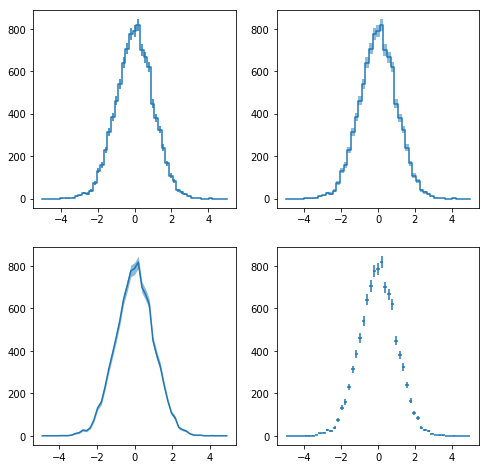

In [8]:
fig, ax = plt.subplots (2, 2, figsize=(8, 8))
hl.plot1d (ax[0][0], h, errorbars=True)
hl.plot1d (ax[0][1], h, errorbands=True)
hl.plot1d (ax[1][0], h, errorbands=True, drawstyle='default')
hl.plot1d (ax[1][1], h, crosses=True)

You have probably noticed that the plotting style differs from matplotlib's standard:

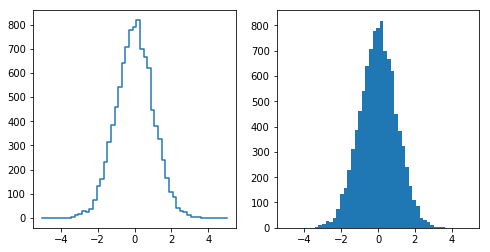

In [9]:
fig, ax = plt.subplots (1, 2, figsize=(8, 4))
hl.plot1d (ax[0], h)
ax[1].hist (x, bins=h.bins[0]);

As we will see, much of the design of histlite is centered on simply dealing with binned rather than smooth curves.  However, the classic matplotlib style (and more) can still be obtained:

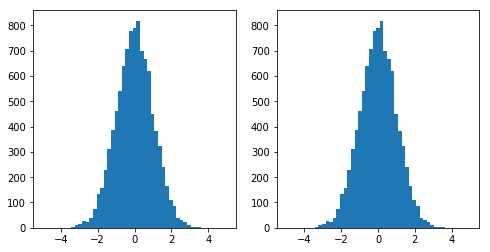

In [10]:
fig, ax = plt.subplots (1, 2, figsize=(8, 4))
hl.fill_between (ax[0], 0, h)
ax[0].set_ylim (0)
ax[1].hist (x, bins=h.bins[0]);

## Data model

The "light" in histlite refers to the deliberately simple data structure.  A histlite histogram is essentially just a bundle of bins, values, and error estimates.  These are the required initialization arguments which are determined from data and arguments to factory functions such as `histlite.hist()`.  They are also read-only properties of each `Hist`:

In [11]:
print (h.bins)
print (h.values)
print (h.errors)

[array([-5.        , -4.80392157, -4.60784314, -4.41176471, -4.21568627,
       -4.01960784, -3.82352941, -3.62745098, -3.43137255, -3.23529412,
       -3.03921569, -2.84313725, -2.64705882, -2.45098039, -2.25490196,
       -2.05882353, -1.8627451 , -1.66666667, -1.47058824, -1.2745098 ,
       -1.07843137, -0.88235294, -0.68627451, -0.49019608, -0.29411765,
       -0.09803922,  0.09803922,  0.29411765,  0.49019608,  0.68627451,
        0.88235294,  1.07843137,  1.2745098 ,  1.47058824,  1.66666667,
        1.8627451 ,  2.05882353,  2.25490196,  2.45098039,  2.64705882,
        2.84313725,  3.03921569,  3.23529412,  3.43137255,  3.62745098,
        3.82352941,  4.01960784,  4.21568627,  4.41176471,  4.60784314,
        4.80392157,  5.        ])]
[  0.   0.   0.   0.   0.   1.   1.   1.   4.  11.  15.  27.  24.  38.
  75. 132. 159. 230. 313. 386. 461. 542. 641. 706. 777. 788. 818. 700.
 666. 619. 448. 381. 325. 240. 166. 108.  85.  39.  29.  23.  10.   4.
   3.   3.   0.   0.   1.   0. 

Note that `bins` is a list of per-axis ndarrays.  Here we have a 1D histogram, and so a single axis, but in general histlite histograms are N-dimensional.  Note also that the errors are $\sqrt{N}$ per bin for unweighted histograms, which is a special case for a general implementation where the errors are $\sqrt{\left(\sum_i w_i^2\right)}$ for events $\{i\}$ per bin for weighted histograms.

On construction, it is determined whether bins are log-spaced (which can be conveniently requested of `histlite.hist()`, as we will see later).  This information is exposed as an array of per-axis bools:

In [12]:
print (h.log)

[False]


We also access to the per-axis number of bins, binning ranges, and bin centers:

In [13]:
print (h.n_bins)
print (h.range)
print (h.centers)

[51]
[(-5.0, 5.0)]
[array([-4.90196078, -4.70588235, -4.50980392, -4.31372549, -4.11764706,
       -3.92156863, -3.7254902 , -3.52941176, -3.33333333, -3.1372549 ,
       -2.94117647, -2.74509804, -2.54901961, -2.35294118, -2.15686275,
       -1.96078431, -1.76470588, -1.56862745, -1.37254902, -1.17647059,
       -0.98039216, -0.78431373, -0.58823529, -0.39215686, -0.19607843,
        0.        ,  0.19607843,  0.39215686,  0.58823529,  0.78431373,
        0.98039216,  1.17647059,  1.37254902,  1.56862745,  1.76470588,
        1.96078431,  2.15686275,  2.35294118,  2.54901961,  2.74509804,
        2.94117647,  3.1372549 ,  3.33333333,  3.52941176,  3.7254902 ,
        3.92156863,  4.11764706,  4.31372549,  4.50980392,  4.70588235,
        4.90196078])]


## Working with multiple histograms

Let's generate data for a second histogram:

In [14]:
x2 = np.random.normal (loc=1, scale=2, size=int (x.size/2))

We would like a second histogram, `h2`, to be used with the original one, `h`.  For this, we require the binning to match.  One way this can be achieved is to bin `x2` using `h.bins`:

In [15]:
h2 = hl.hist (x2, bins=h.bins)

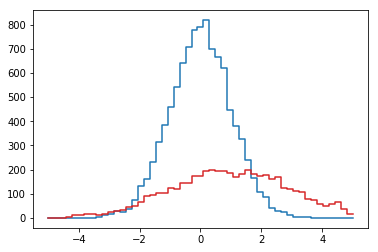

In [16]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h)
hl.plot1d (ax, h2)

This can also be expressed as follows:

In [17]:
h2 = hl.hist_like (h, x2)

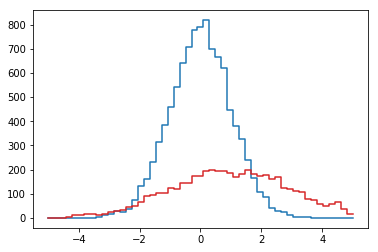

In [18]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h)
hl.plot1d (ax, h2)

We can perform a number of intuitive operations using these two histograms.  The most obvious application is to sum them:

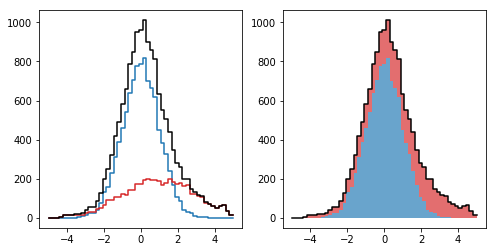

In [19]:
fig, axs = plt.subplots (1, 2, figsize=(8, 4))

ax = axs[0]
hl.plot1d (ax, h)
hl.plot1d (ax, h2)
hl.plot1d (ax, h + h2, color='k')

ax = axs[1]
hl.stack1d (ax, [h, h2], colors='C0 C1'.split (), alpha=.67, lw=0)
hl.plot1d (ax, h + h2, color='k')

We can also create more elaborate constructs — and standard error propagation will be applied throughout:

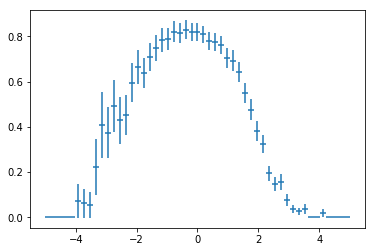

In [20]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h / (h + h2), crosses=True)

An observant reader may notice that in this particular case, the errors on `h` and `h + h2` are correlated, and thus naive error propagation overestimates the errors.  Histlite provides a convenient way to obtain error estimates with proper coverage for the special case of $\text{denominator} = \text{numerator} + \text{something else}$:

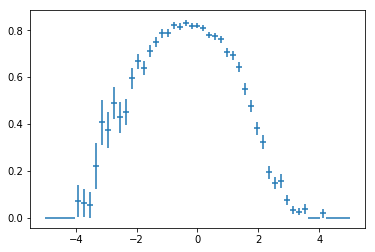

In [21]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h.efficiency (h + h2), crosses=True)

We also see from the above examples that `histlite.Hist` is not strictly required to be meaningfully interpretted as a "histogram" in the classic sense.  For example, it is perfectly happy with negative values:

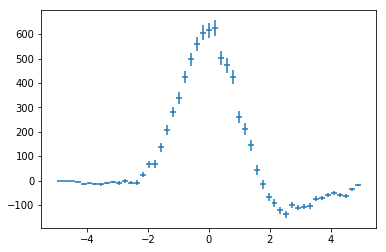

In [22]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h - h2, crosses=True)

One can imagine constructing a highly descriptive class hierarchy to represent all manner of data structures that boil down to "values and errors per bin".  For histlite, we made the design decision to represent all of these with `histlite.Hist` to avoid the sort of complexity we see in, for example, integer to float promotion under division.

## First 2D histogram

As mentioned above, histlite is fully generalized to N-dimensions throughout, with no special-casing for specific numbers of dimensions.  Let's try constructing a 2D histogram:

In [23]:
y = np.random.normal (loc=0, scale=2, size=x.size)

In [24]:
hh = hl.hist ((x, y), bins=51, range=(-5, 5))

We can plot this histogram, `hh`, easily like so:

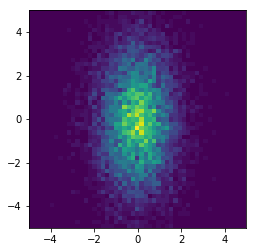

In [25]:
fig, ax = plt.subplots ()
ax.set_aspect ('equal')
hl.plot2d (ax, hh)

We have a number of options for customizing this plot.  Let's try adding a colorbar, log-scaling the colormap, and specifying the color limits:

{'colormesh': <matplotlib.collections.QuadMesh at 0x7fbb35681358>,
 'colorbar': <matplotlib.colorbar.Colorbar at 0x7fbb356a7940>}

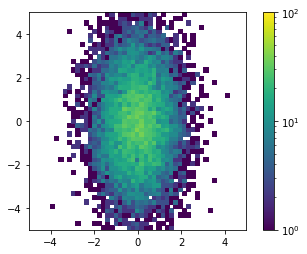

In [26]:
fig, ax = plt.subplots ()
ax.set_aspect ('equal')
hl.plot2d (ax, hh, cbar=True, log=True, vmin=1, vmax=1e2)

Unlike the `histlite.plot1d()` case, it is often convenient to customize the underlying matplotlib objects after `histlite.plot2d()` is finished.  For example, we may want to label the colorbar.  We can do this by digging into the dictionary returned by `histlite.plot2d()`:

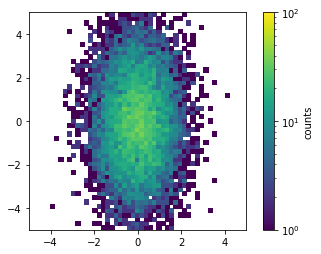

In [27]:
fig, ax = plt.subplots ()
ax.set_aspect ('equal')
d = hl.plot2d (ax, hh, cbar=True, log=True, vmin=1, vmax=1e2)
d['colorbar'].set_label ('counts')

## Brief survey of additional features

In this tutorial, we try to cover the basics that will let you start making plots as quickly as possible.  Histlite has much more to offer.  We will cover the details in other notebooks, but here we offer a teaser with little to no explanation.

### Normalization

Hist(51 bins in [-5.0,5.0]) with sum 5.1, 11 empty bins, and 0 non-finite values
integral of hn is 1.0


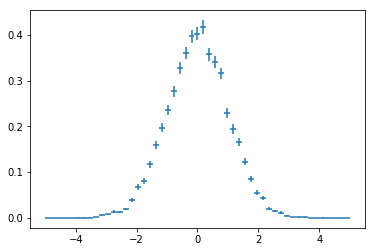

In [28]:
fig, ax = plt.subplots ()
hn = h.normalize ()
print (hn)
print ('integral of hn is', hn.integrate ().values)
hl.plot1d (ax, hn, crosses=True)

{'colormesh': <matplotlib.collections.QuadMesh at 0x7fbb35c7a9e8>,
 'colorbar': <matplotlib.colorbar.Colorbar at 0x7fbb35937320>}

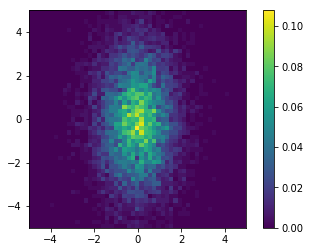

In [29]:
fig, ax = plt.subplots ()
ax.set_aspect ('equal')
hl.plot2d (ax, hh.normalize (), cbar=True)

### Pseudo-KDE (kernel density estimation)

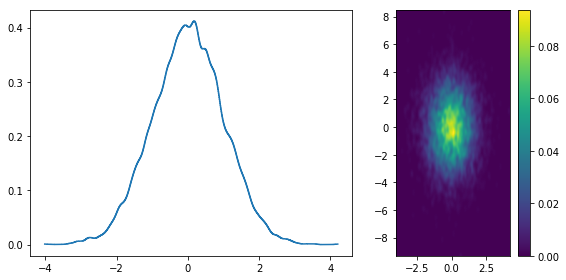

In [30]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(8, 4), gridspec_kw=dict (width_ratios=(2,1)))
hl.plot1d (ax1, hl.kde (x))
hl.plot2d (ax2, hl.kde ((x, y)), cbar=True)
ax2.set_aspect ('equal')
plt.tight_layout ()

### Axis transformation

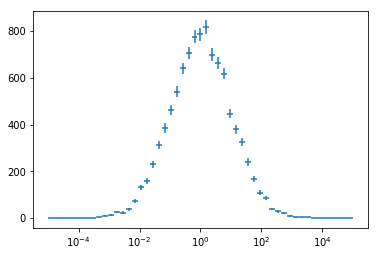

In [31]:
fig, ax = plt.subplots ()
h_exp = h.transform_bins (lambda x: 10**x)
ax.semilogx ()
hl.plot1d (ax, h_exp, crosses=True)

### Cumulative sums

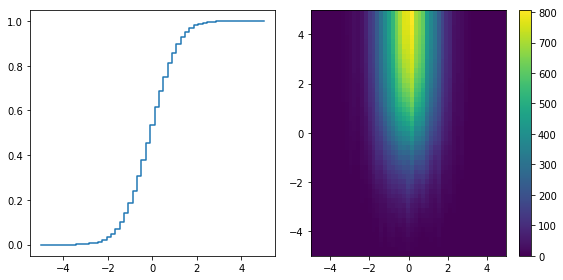

In [32]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(8, 4))
hl.plot1d (ax1, h.cumsum () / h.sum ())
hl.plot2d (ax2, hh.cumsum (), cbar=True)
plt.tight_layout ()

### Projections

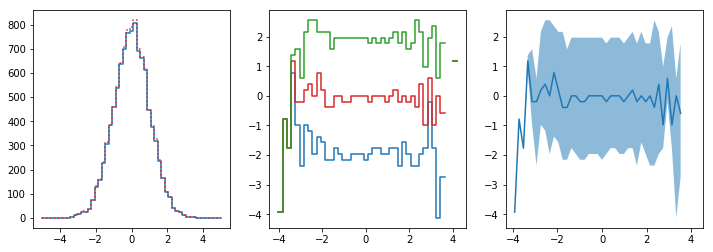

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=(12,4))
hl.plot1d (ax1, hh.project ([0]))
hl.plot1d (ax1, h, ls=':') # slightly more elements since some y's were under/overflow

for frac in (.16, .5, .84):
    hl.plot1d (ax2, hh.contain (-1, frac))

hl.plot1d (ax3, hh.contain_project (-1),  # 1σ errors by default
           drawstyle='default', errorbands=True)

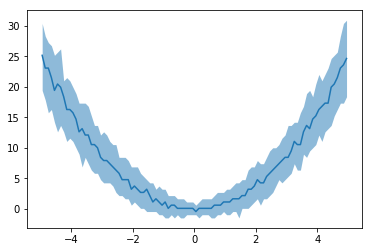

In [34]:
fig, ax = plt.subplots ()
x3 = np.random.uniform (-5, 5, size=10**4)
y3 = np.random.normal (loc=x3**2, scale=1 + np.abs (x3))
hl.plot1d (ax, hl.hist ((x3, y3), bins=100).contain_project (-1),
           errorbands=True, drawstyle='default')

### Values transformation

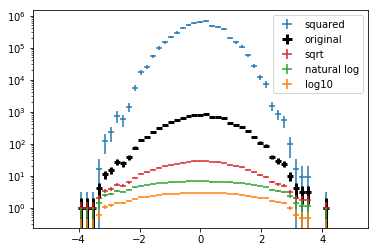

In [35]:
fig, ax = plt.subplots ()
kw = dict (crosses=True)
hl.plot1d (ax, h**2, label='squared', **kw)
hl.plot1d (ax, h, label='original', color='k', lw=3, **kw)
hl.plot1d (ax, h.sqrt (), label='sqrt', **kw)
hl.plot1d (ax, h.ln (), label='natural log', **kw)
hl.plot1d (ax, h.log10 (), label='log10', **kw)
ax.semilogy (nonposy='clip')
ax.legend ();

### Transpose

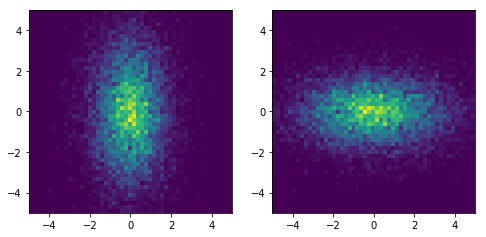

In [36]:
fig, ax = plt.subplots (1, 2, figsize=(8, 8))
hl.plot2d (ax[0], hh)
hl.plot2d (ax[1], hh.T)
for a in ax:
    a.set_aspect ('equal')

### Smoothing

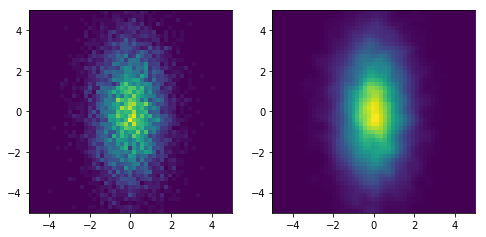

In [37]:
fig, ax = plt.subplots (1, 2, figsize=(8, 8))
hl.plot2d (ax[0], hh)
hl.plot2d (ax[1], hh.gaussian_filter (1))
for a in ax:
    a.set_aspect ('equal')

### Spline Fit

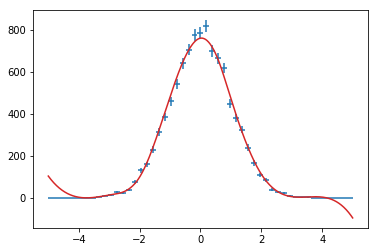

In [38]:
fig, ax = plt.subplots ()
hl.plot1d (ax, h, crosses=True)

X = np.linspace (-5, 5, 1000)
s = h.spline_fit ()
ax.plot (X, s(X))  # naturally, overshoots in region without data...

### Function fit

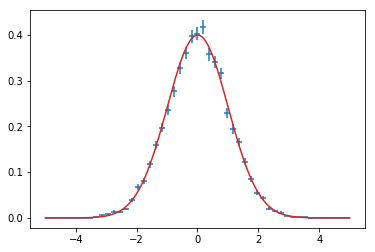

In [39]:
fig, ax = plt.subplots ()
hl.plot1d (ax, hn, crosses=True)

params, cov = hn.curve_fit (lambda x, loc, scale: stats.norm.pdf (x, loc, scale))
ax.plot (X, stats.norm.pdf (X, *params))

### Slicing in binning units

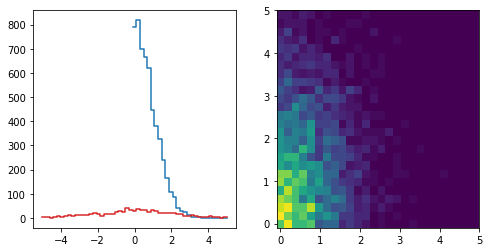

In [40]:
fig, ax = plt.subplots (1, 2, figsize=(8, 4))
hl.plot1d (ax[0], h[0:])
hl.plot1d (ax[0], hh[0])
hl.plot2d (ax[1], hh[0:,0:])